In [ ]:
!python -m spacy download en_core_web_lg

/usr/bin/python3: No module named -q


In [ ]:
!pip install -q transformers  rouge-score

     |████████████████████████████████| 2.6 MB 16.6 MB/s 
     |████████████████████████████████| 3.3 MB 47.3 MB/s 
     |████████████████████████████████| 636 kB 56.8 MB/s 
     |████████████████████████████████| 895 kB 52.9 MB/s 


In [ ]:
import tensorflow_datasets as tfds 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy
from tqdm.notebook import tqdm

import tensorflow_hub as hub
from tensorflow import keras 
import tensorflow as tf
from IPython.display import Image 
import matplotlib.pyplot as plt

import os 
nlp = spacy.load('en_core_web_sm')
os.makedirs("data", exist_ok=True)
sum_dir = "drive/MyDrive/mlexperiments/extractivesummarization/"

## CNN/Daily Mail Dataset

 - The CNN/DailyMail dataset contains 287K documents, each with 3-4 highlights that summarize the contents of the article. 
- Load preprocessed version of documents and highlights 

In [ ]:
import tensorflow_datasets as tfds
import pandas as pd
import pickle 

def load_pickle(file_path):
  with open(file_path, 'rb') as handle:
    return pickle.load(handle)


In [ ]:
!ls drive/MyDrive/mlexperiments/extractivesummarization/data/test


doc_dict.pickle  doc_sents.pickle  sents_dict.pickle  test.json


In [ ]:
cnn_df = pd.read_json(sum_dir + "data/test/test.json") 

## Construct Dictionaries (Spacy)

- Dictionary of documents - id -> text, or id -> embedding 
- Dictionary of sentences - id -> (docid, text), or id -> (docid, textembedding) 
- Dictionary of document embeddings .. as average of each each sentence embedding.



In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split( cnn_df, test_size=0.2, random_state=42)
train_df.shape, test_df.shape

((9192, 2), (2298, 2))

In [ ]:
def get_dicts(df, folder="test"):   
  sents_dict = {}
  doc_dict = { i: {"article": df.article[i], "highlight": df.highlights[i]} for i in df.index }
    
  doc_sents = {}
  sents_list = []

  i = 0
  min_sent_length = 14
  for k in tqdm(doc_dict.keys()):
    article = doc_dict[k]["article"]  
    sents = nlp(article).sents
    doc_sent_ids = []
    sent_text = []
    for sent in sents:
      if (len(sent)) > min_sent_length:
        sents_dict[i] = {"docid":k, "text": str(sent)} 
        sents_list.append({"sentid":i, "docid":k, "text": str(sent) })
        doc_sent_ids.append(i)
        sent_text.append(str(sent))
        i += 1  
        
    doc_sents[k] = doc_sent_ids

  # save dicts
  return doc_dict, sents_dict, doc_sents , sents_list

In [ ]:
test_doc_dict, test_sents_dict, test_doc_sents, test_sents_list = get_dicts(test_df)

  0%|          | 0/2298 [00:00<?, ?it/s]

In [ ]:
train_doc_dict, train_sents_dict, train_doc_sents, train_sents_list = get_dicts(train_df)

  0%|          | 0/9192 [00:00<?, ?it/s]

In [ ]:
from rouge_score import rouge_scorer 
scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

def get_rougue_score(text, highlights, metric="rougeL"):
  max_score = 0
  for h_text in highlights:
    score =  scorer.score(text, h_text)[metric].fmeasure
    # print(score, text, "\n \t" , h_text)
    if score > max_score:
      max_score = score 
  return max_score 


def get_label(sent, doc_dict,  score_threshold = 0.55):
  sent_id, doc_id, text = sent["sentid"], sent["docid"], sent["text"]  
  highlights = doc_dict[doc_id]["highlight"].split("\n")
  doc = doc_dict[doc_id]["article"]

  label_score = get_rougue_score(text, highlights) 
  # Normalize label to 0/1 based on rogue score threshold
  label_score = 0 if label_score < score_threshold else 1 
  return (text, doc, label_score)
  

In [ ]:
batch_size = 32

def train_generator():
    for sent in train_sents_list:
      x1, x2, y = get_label(sent, train_doc_dict)
      yield {"sentence": x1, "document": x2}, y

def test_generator():
    for sent in test_sents_list:
      x1, x2, y = get_label(sent, test_doc_dict)
      yield {"sentence": x1, "document": x2}, y

auto = tf.data.AUTOTUNE

In [ ]:
train_ds = tf.data.Dataset.from_generator(train_generator, 
                                          output_signature=({"sentence": tf.TensorSpec(shape=(None), dtype=tf.string, name="sentence"), 
                                                             "document": tf.TensorSpec(shape=(None), dtype=tf.string, name="document")}, 
                                                           tf.TensorSpec(shape=(None), dtype=tf.int64, name="label"))
                                          )
train_ds = train_ds.batch(batch_size).prefetch(auto)


In [ ]:
# train_ds = tf.data.Dataset.from_generator(train_generator, output_types=({"sentence": tf.string, "document": tf.string}, tf.int64))
# train_ds = train_ds.batch(batch_size).prefetch(auto)


In [ ]:
val_ds = tf.data.Dataset.from_generator(test_generator,  output_signature=({"sentence": tf.TensorSpec(shape=(None), dtype=tf.string, name="sentence"), 
                                                             "document": tf.TensorSpec(shape=(None), dtype=tf.string, name="document")}, 
                                                           tf.TensorSpec(shape=(None), dtype=tf.int64, name="label")),
                                         
                                          )
val_ds = val_ds.batch(batch_size).prefetch(auto)

In [ ]:
for x,y in train_ds.take(1):
  print(x)

{'sentence': <tf.Tensor: shape=(32,), dtype=string, numpy=
array([b"A dog breeder and her husband have been jailed for animal cruelty after their animals were found in the 'worst conditions ever seen'.",
       b'Margaret and Gary Mazan from Bradford, West Yorkshire, had their 14 Red Setters seized by RSPCA inspectors after the animals were discovered in filthy cages in a garden shed.',
       b'The court heard how the animals had matted fur, were dehydrated and had not been provided with a suitable diet.',
       b'Margaret Mazan (pictured) and her husband Gary were found guilty of animal cruelty after their 14 Red Setters were found in appalling conditions .',
       b'Sentenced: Margaret (left) and Gary Mazan (right) were jailed for 26 weeks and given a lifetime ban from owning or keeping pets, which they cannot appeal for 25 years .',
       b'Three of the fully grown dogs were found by inspectors crammed in puppy cages and the majority were kept in a squalid garden shed.',
       

## Class Weights to Handle Imbalance 

Most sentences in a docomunet are just not relevant to the summary; this means a majority of the labels for sentence samples are 0. Huge class imbalance. We can use loss weighted trianing to help handle this. 

In [ ]:
def get_label_list(ds):
  labels = [ y.numpy() for x,y in ds.unbatch() ] 
  return np.array(labels)

train_labels = get_label_list(train_ds)
train_labels_ohe = keras.utils.to_categorical(train_labels)

class_totals = train_labels_ohe.sum(axis=0)
class_weight = dict()

for i in range(0, len(class_totals)):
	class_weight[i] = class_totals.max() / class_totals[i]

class_weight

{0: 1.0, 1: 25.719673}

## Build A Model 

In [ ]:
import tensorflow_hub as hub
from tensorflow import keras 
import tensorflow as tf
from IPython.display import Image 
import matplotlib.pyplot as plt 

encoding_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',  trainable=True, name="embedding")

In [ ]:
def get_model():
  input_a = keras.Input(shape=[] ,dtype=tf.string, name="sentence") 
  input_b = keras.Input(shape=[] ,dtype=tf.string, name="document") 

  embedding_a = encoding_layer(input_a)
  embedding_b = encoding_layer(input_b)


  x = keras.layers.Concatenate(name="concat")([embedding_a, embedding_b])

  x = keras.layers.Dense(32,activation='relu')(x) 
  output = keras.layers.Dense(1, activation="sigmoid")(x)

  model = keras.Model([input_a, input_b], output, name="extractive_model") 
  tf.keras.utils.plot_model(model, to_file="model.png", show_shapes=True) 
  return model 

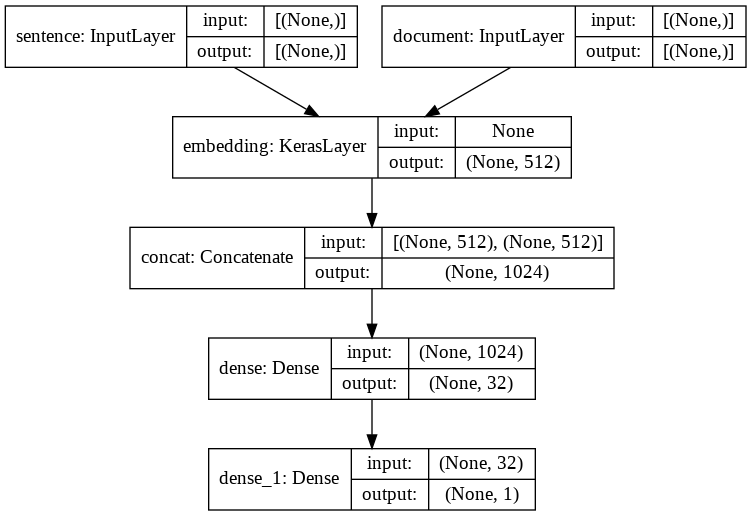

In [ ]:
model = get_model()
Image("model.png")

In [ ]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              # loss = "categorical_crossentropy" 
              # loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy()] 
              # metrics = ['accuracy']
              )


In [ ]:
def plot_history(history, title=""): 
   
  # Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Losss | ' + title)
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')

  
  plt.show()

In [ ]:
history = model.fit(train_ds,
                     validation_data=val_ds, 
                     epochs=2, 
                    #  steps_per_epoch = 5,
                    #  class_weight=class_weight
                    )

Epoch 1/2
7551/7551 [==============================] - 1861s 245ms/step - loss: 0.1542 - binary_accuracy: 0.9625 - val_loss: 0.1465 - val_binary_accuracy: 0.9636
Epoch 2/2
7551/7551 [==============================] - 1861s 246ms/step - loss: 0.0793 - binary_accuracy: 0.9754 - val_loss: 0.1860 - val_binary_accuracy: 0.9453


In [ ]:
class_weight

{0: 1.0, 1: 25.719673}

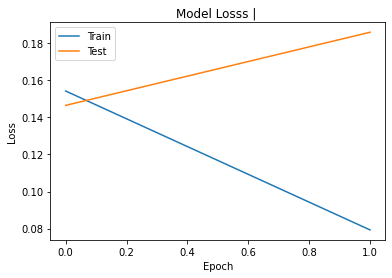

In [ ]:
plot_history(history, title="")

In [ ]:
history.history

{'binary_accuracy': [0.9625049829483032, 0.9754037857055664],
 'loss': [0.15424863994121552, 0.07928810268640518],
 'val_binary_accuracy': [0.9636034965515137, 0.9452977776527405],
 'val_loss': [0.14648936688899994, 0.18596890568733215]}

In [ ]:
preds = model.predict(val_ds)

In [ ]:
def save_model(name, model):
  print(">>> Saving model", name) 
  model_dir = "models/"+name
  tf.keras.models.save_model(model, model_dir, save_traces=True, include_optimizer=False) 

In [ ]:
os.makedirs("models")
save_model("extractive", model)

>>> Saving model extractive
INFO:tensorflow:Assets written to: models/extractive/assets


INFO:tensorflow:Assets written to: models/extractive/assets


In [ ]:
!gsutil cp -r models $sum_dir

Copying file://models/extractive/keras_metadata.pb...
Copying file://models/extractive/saved_model.pb...
Copying file://models/extractive/variables/variables.data-00000-of-00001...
Copying file://models/extractive/variables/variables.index...
- [4 files][988.2 MiB/988.2 MiB]                                                
Operation completed over 4 objects/988.2 MiB.                                    


In [ ]:
!ls -lh models/extractive/variables/

total 980M
-rw-r--r-- 1 root root 980M Aug 16 17:42 variables.data-00000-of-00001
-rw-r--r-- 1 root root  13K Aug 16 17:42 variables.index


In [ ]:
!rm -rf models 

In [ ]:
lmodel = tf.keras.models.load_model( "models/extractive")

## Online Evaluation
Given a new document
- Construct sentences using spacy. Only sentences with length > 14 are included
-  Construct pairs into a batch .. e.g. each sentence and the entire document
-  Get score predictions for each sentence 

## Post Processing 
- Construct list of senctence dictionaries - {sent, score, index} prediction and index as it appears in document
- Sort list by score 
- Take the top n sentences to be included in summary 
- Sort top n by order of appearance (and any other metric)

In [ ]:
!python -m spacy download en_core_web_lg

     |████████████████████████████████| 827.9 MB 1.2 MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-py3-none-any.whl size=829180942 sha256=fd9738f762d609b15cba73b50480a278606f73a306e2ef9b92bd239b9adf0979
  Stored in directory: /tmp/pip-ephem-wheel-cache-aom0xcrp/wheels/11/95/ba/2c36cc368c0bd339b44a791c2c1881a1fb714b78c29a4cb8f5
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [ ]:
# nlplg = spacy.load('en_core_web_lg')

In [ ]:
article = """ Gone are the days of running to the ATM in order to get cash to tip your server or hair stylist. If cash was going out of style before the pandemic, consider its reputation ruined by infection concerns that have pushed consumers toward cashless alternatives — especially when it comes to tipping. Apps like Venmo, Cash App and PayPal let users easily facilitate peer-to-peer payments. And Apple and Google both have their own digital payment and wallet services. But while cashless tipping may be a consumer convenience, does it benefit service workers who have traditionally relied on cash tips? Bigger tips as a matter of convenience Digital payment systems often give customers the option to select a pre-calculated tip which, according to several companies that offer these services, often result in larger tips. For example, digital payment company Square allows merchants to select between a “smart tip” or a custom tip. When smart tip is turned on, transactions of less than $10 offer four tipping options: No Tip, $1, $2 or $3. For a transaction of $10 or more, the available tipping options are: No Tip, 15%, 20% or 25%. The custom tip setting allows businesses to select their own options. Another cashless payment service, Youtip uses QR codes to facilitate digital tipping and offers similar pre-calculated options for users called “Quick Tips.” After scanning a QR code, users are prompted to either enter a tip amount or select a “Quick Tip” option, which is a fixed amount set by the system or the business. According to the company’s data, over 70% of tips processed through the system are either a “Quick Tip” selection or higher, Sarah Taveprungsenukul, Youtip co-founder and chief commercial officer, told CNN Business. youtip, a digital payment service made specifically for cashless tipping, offers users "Quick Tip" options with pre-calculated tips. youtip, Inc. youtip, a digital payment service made specifically for cashless tipping, offers users "Quick Tip" options with pre-calculated tips. One lodging business that adopted Youtip’s system reported that it saw housekeeping tips rise from an average of $14 to $21 with the implementation of the QR codes and customized “Quick Tip” prompts, according to Youtip’s data. Tippy, another digital payment service, has seen similar increases. Originally created for the beauty industry, Tippy’s data shows that not only are people tipping more often when its cashless system is used, but the average tip has increased 11% since early 2020. “We’re encouraging people to tip more because we’re doing the calculation for them,” Terry McKim, Tippy’s founder and CIO, told CNN Business. Cashless options are also changing tipping norms, encouraging tips for workers who don’t usually receive them, like fast food servers or fitness instructors, according to Taveprungsenukul. “Tipping is everywhere and even the places where it isn’t, maybe it should be,” she said. “We’re working with a lot of groups, for example in quick-serve restaurants, where they’re implementing our solution.” The downsides of cashless tips Despite the convenience of cashless payments and tips, some service workers still prefer cash. For example, some workers don’t have access to the banking tools necessary to accept and process digital payments, Clara Wheatley-Schaller, political director at Workers United NY NJ, told CNN Business. “With anything that is cashless tipping, that would be the main concern: making sure the money is accessible and going directly to the worker,” she said. More than 80% of workers represented by Workers United, which represents a variety of service workers, experience some kind of wage theft, according to the union’s survey data. When customers add tips on their credit card, the money doesn’t always go directly to the worker. Those tips might get cut due to processing fees, for example. Because of this, some workers don’t trust that they’re getting all their cashless tips. Handing cash directly to a worker is the safest way to ensure they are getting the entirety of their tip, Whetley-Schaller said. D. Taylor, president of Unite Here, a union representing workers in the hotel and food service industries, has observed that workers benefit when there are pre-calculated tip options. But he said the union has struggled to find solutions that make cashless tipping easy for both the consumer and the worker. Most digital payment companies take a cut of the tips paid through their services, and it can be hard to ensure that tips are going to the intended workers, Taylor said. Tippy, for example, said it charges businesses a flat annual rate of $300 for the use of its services. And, instead of charging workers processing fees for using its software, the service charges the customer leaving a tip a fee for use of the system. Similarly, Youtip applies a service fee to the person paying the tip, but businesses have the option to cover that fee for customers. Another issue with digital tipping: taxes. While both cash and digital tips are taxable, cash is self-reported, so it’s easier for some payments to remain under the table. But, as tipping on credit cards has grown more popular in past years, paying taxes on tips is “old news,” Taylor said. For workers who are used to taking cash tips without always reporting them, digital tipping might actually alleviate their tax concerns. Although they’ll have to pay taxes on their tips, using digital payment services can increase tips enough to offset the cost of taxes, said David Tashjian, Tippy’s CEO and president. Adapting to a cashless economy is “not even a question of interest. It’s going to happen,” Taylor said. “The real question is how can the fruits of [a worker’s] labor be rewarded? And how is that done in a way that they are the beneficiaries of it as opposed to someone taking a cut that had nothing to do with their labor, but just developed an app?” """

In [ ]:
for sent in nlp(article).sents:
  print(sent)

 Gone are the days of running to the ATM in order to get cash to tip your server or hair stylist.
If cash was going out of style before the pandemic, consider its reputation ruined by infection concerns that have pushed consumers toward cashless alternatives — especially when it comes to tipping.
Apps like Venmo, Cash App and PayPal let users easily facilitate peer-to-peer payments.
And Apple and Google both have their own digital payment and wallet services.
But while cashless tipping may be a consumer convenience, does it benefit service workers who have traditionally relied on cash tips?
Bigger tips as a matter of convenience Digital payment systems often give customers the option to select a pre-calculated tip which, according to several companies that offer these services, often result in larger tips.
For example, digital payment company Square allows merchants to select between a “smart tip” or a custom tip.
When smart tip is turned on, transactions of less than $10 offer four ti

In [ ]:
def summarize(doc, model, min_sentence_length=14, top_k=4):
  doc_sentences = []
  for sent in nlp(doc).sents:
    if len(sent) > min_sentence_length: 
      doc_sentences.append(str(sent))
  
  model_input =   {"sentence":  tf.convert_to_tensor(doc_sentences, dtype=tf.string) , "document": tf.convert_to_tensor([doc] * len(doc_sentences), dtype=tf.string) }
  scores = model.predict(model_input) 

  sent_pred_list = [{"sentence": doc_sentences[i], "score": scores[i][0], "index":i} for i in range(len(doc_sentences))]
  sorted_sentences = sorted(sent_pred_list, key=lambda k: k['score'], reverse=True) 

  sorted_result = sorted_sentences[:top_k] 
  sorted_result = sorted(sorted_result, key=lambda k: k['index']) 

  summary = [ x["sentence"] for x in sorted_result]
  summary = " ".join(summary)

  return summary


In [ ]:
summary = summarize(article, model, top_k=3)
print(summary)

’s system reported that it saw housekeeping tips rise from an average of $14 to $21 with the implementation of the QR codes and customized “Quick Tip” prompts, according to Youtip’s data. The downsides of cashless tips Despite the convenience of cashless payments and tips, some service workers still prefer cash. But, as tipping on credit cards has grown more popular in past years, paying taxes on tips is “old news,” Taylor said.


In [ ]:
art_sents = []
for sent in nlp(article).sents:
  if len(sent) > 14:
    # print(len(sent), sent)
    art_sents.append(str(sent))

In [ ]:
preds = model.predict(doc_rep)

In [ ]:
len(preds), len(art_sents)

(38, 38)

In [ ]:
sent_pred_list = [{"sentence": art_sents[i], "score": preds[i][0], "index":i} for i in range(len(art_sents))]

In [ ]:
sent_pred_list[:2]

[{'index': 0,
  'score': 0.06900206,
  'sentence': ' Gone are the days of running to the ATM in order to get cash to tip your server or hair stylist.'},
 {'index': 1,
  'score': 0.012387447,
  'sentence': 'If cash was going out of style before the pandemic, consider its reputation ruined by infection concerns that have pushed consumers toward cashless alternatives — especially when it comes to tipping.'}]

In [ ]:
sorted_sentences = sorted(sent_pred_list, key=lambda k: k['score'], reverse=True) 

In [ ]:
top_k = 5
sorted_result = sorted_sentences[:5]
sorted_result  

[{'index': 19,
  'score': 0.7550852,
  'sentence': 'The downsides of cashless tips Despite the convenience of cashless payments and tips, some service workers still prefer cash.'},
 {'index': 13,
  'score': 0.31116402,
  'sentence': '’s system reported that it saw housekeeping tips rise from an average of $14 to $21 with the implementation of the QR codes and customized “Quick Tip” prompts, according to Youtip’s data.'},
 {'index': 33,
  'score': 0.13683037,
  'sentence': 'But, as tipping on credit cards has grown more popular in past years, paying taxes on tips is “old news,” Taylor said.'},
 {'index': 3,
  'score': 0.13030703,
  'sentence': 'But while cashless tipping may be a consumer convenience, does it benefit service workers who have traditionally relied on cash tips?'},
 {'index': 7,
  'score': 0.1103212,
  'sentence': 'For a transaction of $10 or more, the available tipping options are: No Tip, 15%, 20% or 25%.'}]

In [ ]:
sorted_result = sorted(sorted_result, key=lambda k: k['index'])
sorted_result

[{'index': 3,
  'score': 0.13030703,
  'sentence': 'But while cashless tipping may be a consumer convenience, does it benefit service workers who have traditionally relied on cash tips?'},
 {'index': 7,
  'score': 0.1103212,
  'sentence': 'For a transaction of $10 or more, the available tipping options are: No Tip, 15%, 20% or 25%.'},
 {'index': 13,
  'score': 0.31116402,
  'sentence': '’s system reported that it saw housekeeping tips rise from an average of $14 to $21 with the implementation of the QR codes and customized “Quick Tip” prompts, according to Youtip’s data.'},
 {'index': 19,
  'score': 0.7550852,
  'sentence': 'The downsides of cashless tips Despite the convenience of cashless payments and tips, some service workers still prefer cash.'},
 {'index': 33,
  'score': 0.13683037,
  'sentence': 'But, as tipping on credit cards has grown more popular in past years, paying taxes on tips is “old news,” Taylor said.'}]

In [ ]:
output = [ x["sentence"] for x in sorted_result]
output = " ".join(output)
print(output)

But while cashless tipping may be a consumer convenience, does it benefit service workers who have traditionally relied on cash tips? For a transaction of $10 or more, the available tipping options are: No Tip, 15%, 20% or 25%. ’s system reported that it saw housekeeping tips rise from an average of $14 to $21 with the implementation of the QR codes and customized “Quick Tip” prompts, according to Youtip’s data. The downsides of cashless tips Despite the convenience of cashless payments and tips, some service workers still prefer cash. But, as tipping on credit cards has grown more popular in past years, paying taxes on tips is “old news,” Taylor said.
